<a href="https://colab.research.google.com/github/Anjalichimnani/CNN_Mask_Estimation/blob/master/CNN_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
! git clone https://github.com/Anjalichimnani/EVA4_Custom_Data.git

Cloning into 'EVA4_Custom_Data'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 373 (delta 32), reused 357 (delta 18), pack-reused 0
Receiving objects: 100% (373/373), 5.51 MiB | 4.46 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/EVA4/Assignment_15/15A/files/')
from imports.imports_eva import *

from supplements.Supplements import Supplements

from dataloaders.custom_data_loader import custom_data_loader
from models.CustomNet import CustomNet
from models.UNet import UNet
from models.Net import Net

In [0]:
import time
import glob
import torch
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [0]:
cd /content/EVA4_Custom_Data/

/content/EVA4_Custom_Data


In [0]:
!mkdir fg_images_flip
!mkdir mask_images_flip

!mkdir fg_bg_images
!mkdir mask_bg_images

!mkdir bg_images_all

In [0]:
root_path = '/content/EVA4_Custom_Data/'

!ls /content/EVA4_Custom_Data

addon_images	     code	     mask_bg_images    reference_images
Assignment15A.ipynb  fg_bg_images    mask_images
bg_images	     fg_images	     mask_images_flip
bg_images_all	     fg_images_flip  README.md


In [0]:
Supplements.flip_image_alpha ('/content/EVA4_Custom_Data/fg_images/', '/content/EVA4_Custom_Data/fg_images_flip/')

In [0]:
Supplements.flip_image_wo_alpha ('/content/EVA4_Custom_Data/mask_images/', '/content/EVA4_Custom_Data/mask_images_flip/')

In [0]:
Supplements.overlay_images (bgpath = '/content/EVA4_Custom_Data/bg_images/', fgpath = '/content/EVA4_Custom_Data/fg_images/', newpath = '/content/EVA4_Custom_Data/fg_bg_images/', name_prefix = 'base', bg_img_size = 224, fg_img_size = 112)

In [0]:
Supplements.overlay_images (bgpath = '/content/EVA4_Custom_Data/bg_images/', fgpath = '/content/EVA4_Custom_Data/fg_images_flip/', newpath = '/content/EVA4_Custom_Data/fg_bg_images/', name_prefix = 'flip', bg_img_size = 224, fg_img_size = 112)

In [0]:
!ls fg_bg_images | wc - l

 400000  400000 12800000 -
wc: l: No such file or directory
 400000  400000 12800000 total


In [0]:
Supplements.overlay_mask_images (bgpath = '/content/EVA4_Custom_Data/addon_images/', fgpath = '/content/EVA4_Custom_Data/mask_images/', newpath = '/content/EVA4_Custom_Data/mask_bg_images/', name_prefix = 'base', bg_img_size = 224, fg_img_size = 112)

In [0]:
Supplements.overlay_mask_images (bgpath = '/content/EVA4_Custom_Data/addon_images/', fgpath = '/content/EVA4_Custom_Data/mask_images_flip/', newpath = '/content/EVA4_Custom_Data/mask_bg_images/', name_prefix = 'flip', bg_img_size = 224, fg_img_size = 112)

In [0]:
Supplements.load_all_images (bgpath = '/content/EVA4_Custom_Data/bg_images/', fgpath = '/content/EVA4_Custom_Data/fg_images/', newpath = '/content/EVA4_Custom_Data/bg_images_all/', name_prefix = 'base', bg_img_size = 224, fg_img_size = 112)

In [0]:
Supplements.load_all_images (bgpath = '/content/EVA4_Custom_Data/bg_images/', fgpath = '/content/EVA4_Custom_Data/fg_images/', newpath = '/content/EVA4_Custom_Data/bg_images_all/', name_prefix = 'flip', bg_img_size = 224, fg_img_size = 112)

In [0]:
!ls bg_images_all | wc - l

 400000  400000 11600000 -
wc: l: No such file or directory
 400000  400000 11600000 total


In [0]:
classes = []


train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [0]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (device)

model = UNet(in_channels=6, out_channels=1).to(device)
summary (model, input_size=(6, 224, 224))
print (model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           3,456
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,728
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,456
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1,

In [0]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (device)

model = CustomNet().to(device)
summary (model, input_size=(6, 64, 64))
print (model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           3,456
       BatchNorm2d-2           [-1, 64, 62, 62]             128
              ReLU-3           [-1, 64, 62, 62]               0
            Conv2d-4          [-1, 128, 60, 60]          73,856
       BatchNorm2d-5          [-1, 128, 60, 60]             256
              ReLU-6          [-1, 128, 60, 60]               0
         MaxPool2d-7          [-1, 128, 30, 30]               0
            Conv2d-8          [-1, 128, 28, 28]         147,584
       BatchNorm2d-9          [-1, 128, 28, 28]             256
             ReLU-10          [-1, 128, 28, 28]               0
           Conv2d-11          [-1, 256, 26, 26]         295,168
      BatchNorm2d-12          [-1, 256, 26, 26]             512
             ReLU-13          [-1, 256, 26, 26]               0
           Conv2d-14            [-

In [0]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (device)

model = Net().to(device)
print (model)

cuda
Net(
  (convblock1_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock1_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convblock2_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-0

In [0]:
data_transform = custom_data_loader.get_def_data_transform()

In [0]:
dataset = custom_data_loader.custom_data_set(root_path = '/content/EVA4_Custom_Data/', folder = 'images', transform = data_transform)
dataset_test = custom_data_loader.custom_data_set(root_path = '/content/EVA4_Custom_Data/', folder = 'images', transform = data_transform)


In [0]:
dataset_loader = custom_data_loader.custom_data_loader (dataset, batch_size=128, num_workers=4, shuffle=True)
test_dataset_loader = custom_data_loader.custom_data_loader (dataset_test, batch_size=128, num_workers=4, shuffle=False)

In [0]:
PATH = '/content/gdrive/My Drive/EVA4/Assignment_15/15A/files/Model_UNet_14_06.pth'

In [0]:
#criterion = nn.L1Loss().cuda()
#criterion = nn.MSELoss().cuda()
#criterion = nn.CrossEntropyLoss().cuda()
criterion = nn.BCEWithLogitsLoss().cuda()

In [0]:
def train(model, device, train_loader, optimizer, epoch, criterion):
  train_losses = []
  train_acc = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data) in enumerate(pbar):
    idx = 0
    # get samples
    images = data["Image"].to(device) 
    image_bgs = data["Image_Bg"].to(device) 
    masks = data["Mask"].to(device)

    image_and_bg = torch.cat ((images,image_bgs), dim = 1)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(image_and_bg)

    # Calculate loss
    criterion = criterion
    loss = criterion(y_pred, masks)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if batch_idx % 1500 == 0:
      torch.save(model.state_dict(), PATH)

    pbar.set_description(desc= f'Loss={loss.item():0.3f} Batch_id={batch_idx} ')
    train_acc.append(loss)

  return train_losses, train_acc

def test(model, device, test_loader):
  model.eval()
  test_losses = []
  test_acc = []
  test_loss = 0
  correct = 0

  with torch.no_grad():
      for idx, data in enumerate(test_loader):
        images = data["Image"].to(device) 
        image_bgs = data["Image_Bg"].to(device)   
        masks = data["Mask"].to(device)

        image_and_bg = torch.cat ((images,image_bgs), dim = 1)

        output = model(image_and_bg)
        criterion = nn.BCEWithLogitsLoss().cuda()
        test_loss += criterion(output, masks).item()  # sum up batch loss


  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: /{} \n'.format(
      test_loss, len(test_loader.dataset)))
  
  test_acc.append(test_loss)
  return test_losses, test_acc

In [0]:
model = CustomNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.000001)  # Removed Weight Decay
scheduler = StepLR(optimizer, step_size=1, gamma=0.01)

In [0]:
from tqdm.notebook import tqdm

EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    a,b = train(model, device, dataset_loader, optimizer, epoch)
    train_losses.extend(a)
    train_acc.extend(b)

    scheduler.step()
    print('')

In [0]:
PATH = '/content/gdrive/My Drive/EVA4/Assignment_15/15A/files/Model_CustomNet_14_06.pth'

In [0]:
model = CustomNet().to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

CustomNet(
  (conv_block_1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block_4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block_5): Sequential(
    (0): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1))
  )

In [0]:
images = iter(dataset_loader).next()

image = images["Image"].to(device)
image_bg = images["Image_Bg"].to(device)
masks = images["Mask"].to(device)

image_and_bg = torch.cat ((image, image_bg), dim = 1)

y_pred = model(image_and_bg)

In [0]:
def show_image(inp, n_row=8, title=None, mean=None, std=None):

    inp = torchvision.utils.make_grid(inp.detach().cpu(), n_row)
    inp = inp.numpy().transpose((1, 2, 0))
    if mean:
        mean = np.array(mean)
        std = np.array(std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


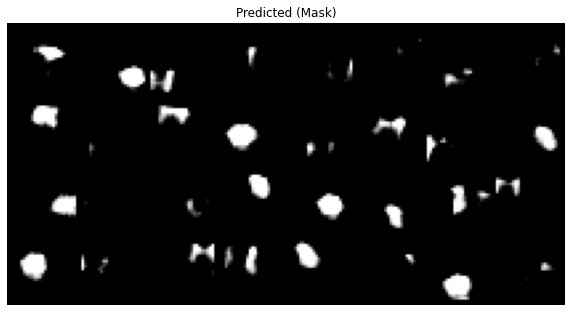

AttributeError: ignored

In [0]:
show_image(y_pred[::4], n_row=8, title='Predicted (Mask)')

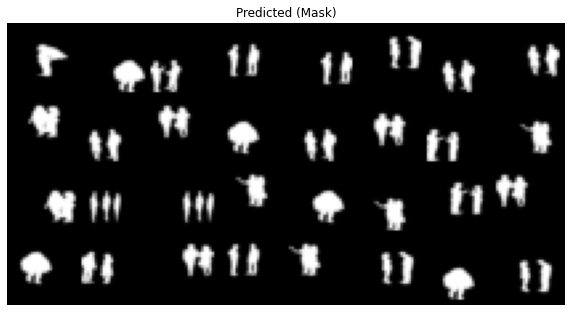

AttributeError: ignored

In [0]:
show_image(masks[::4].cpu(), n_row=8, title='Predicted (Mask)')